In this notebook, we will use traditional machine learning methods to the problem of recommendation systems. We will use the MovieLens dataset, which contains user ratings for movies, along with movie metadata.

Dataset Overview of MovieLens 1M: The dataset contain 1M movie ratings collected from several thousand users. The dataset includes user ratings (on a scale from 1 to 5), user and movie identifiers, and some additional metadata such as movie genres and timestamps of ratings.

Let's start by loading and work with the data in this notebook. For example, to read the ratings.dat file into a pandas DataFrame, we can use:

In [1]:
import pandas as pd

# Update the path according to where the file is located
ratings_file_path = '/Users/victormpreciado/PythonProjects/Networks/Data/MovieLens/ratings.dat'

# Assuming the separator is '::' for the MovieLens dataset
ratings = pd.read_csv(ratings_file_path, sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')

# Display the first few rows of the dataframe
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Let's take a look at the distribution of movie ratings across all users to understand the general tendency of users' ratings. This can be done using a histogram...

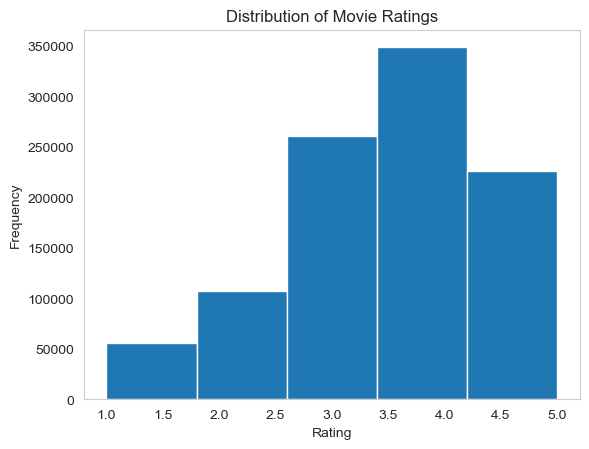

In [2]:
import matplotlib.pyplot as plt

# Assuming 'ratings' DataFrame has a 'Rating' column
ratings['Rating'].hist(bins=5, grid=False)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

We can also take a look at the number of ratings per movie. This can help us detect very popular movies...

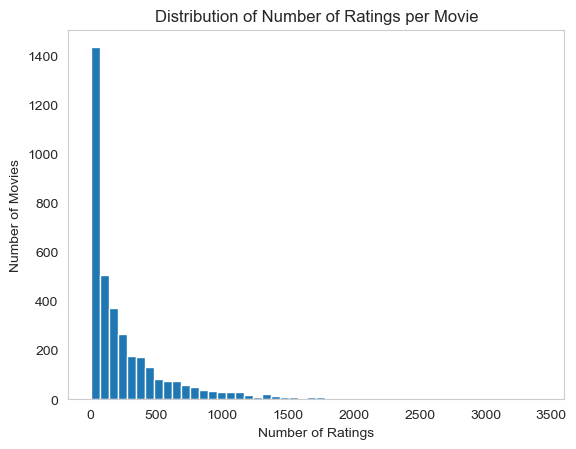

In [3]:
ratings_per_movie = ratings.groupby('MovieID').size()
ratings_per_movie.hist(bins=50, grid=False)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

Similarly, you can visualize the number of ratings provided by each user, which can help identify highly active users.

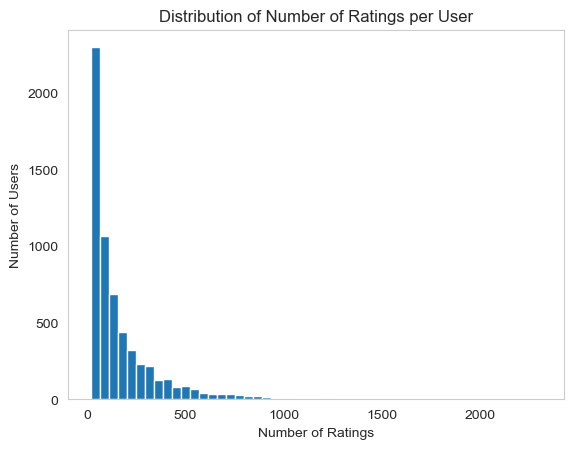

In [4]:
ratings_per_user = ratings.groupby('UserID').size()
ratings_per_user.hist(bins=50, grid=False)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

Plotting the average rating for each movie can help identify universally acclaimed versus controversial movies.

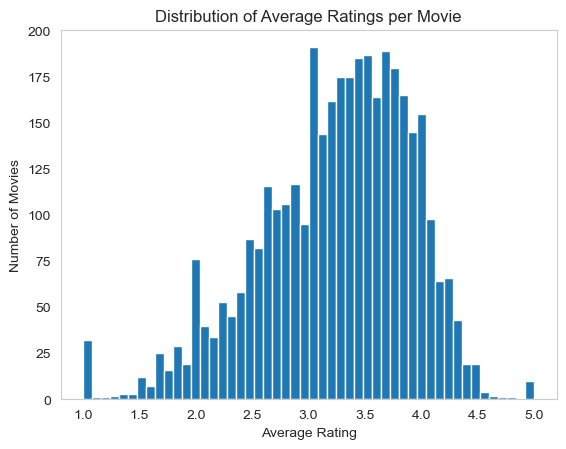

In [5]:
average_movie_ratings = ratings.groupby('MovieID')['Rating'].mean()
average_movie_ratings.hist(bins=50, grid=False)
plt.title('Distribution of Average Ratings per Movie')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.show()

The users.dat file contains user information with the following fields: UserID, Gender, Age, Occupation, and Zip-code.

In [6]:
# Update the path according to where the file is located
users_file_path = '/Users/victormpreciado/PythonProjects/Networks/Data/MovieLens/users.dat'

# Define column names for the users DataFrame
user_columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

# Load the data
users = pd.read_csv(users_file_path, sep='::', header=None, names=user_columns, engine='python')

# Display the first few rows to verify
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


The movies.dat file includes movie information with fields: MovieID, Title, and Genres.

In [7]:
# Update the path according to where the file is located
movies_file_path = '/Users/victormpreciado/PythonProjects/Networks/Data/MovieLens/movies.dat'

# Define column names for the movies DataFrame
movie_columns = ['MovieID', 'Title', 'Genres']

# Load the data with ISO-8859-1 encoding
movies = pd.read_csv(movies_file_path, sep='::', header=None, names=movie_columns, engine='python', encoding='ISO-8859-1')

# Display the first few rows to verify
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


We are now going to create a user-item matrix from the MovieLens dataset. First, we pivot the ratings DataFrame such that users (rows) are associated with their ratings (values) for each movie (columns). The piece of code below demonstrates how to do this using pandas. The built matrix is essential for many recommendation system algorithms, particularly for collaborative filtering methods.

In [8]:
# Assuming ratings is already loaded into a DataFrame named `ratings`
# The ratings DataFrame should have columns: ['UserID', 'MovieID', 'Rating']

# Creating the user-item matrix
user_item_matrix = ratings.pivot_table(index='UserID', columns='MovieID', values='Rating')

# Fill missing values with 0s (assuming that missing values mean unrated movies)
user_item_matrix = user_item_matrix.fillna(0)

# Display the user-item matrix
print(user_item_matrix.head())

MovieID  1     2     3     4     5     6     7     8     9     10    ...  \
UserID                                                               ...   
1         5.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5         0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0  ...   

MovieID  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  
UserID                                                               
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.0   0.0   0.0   0.0   0.0   0.0   0

Although visualizing the entire user-item matrix might not be feasible for large datasets, showing a subset can illustrate the sparsity of the matrix.

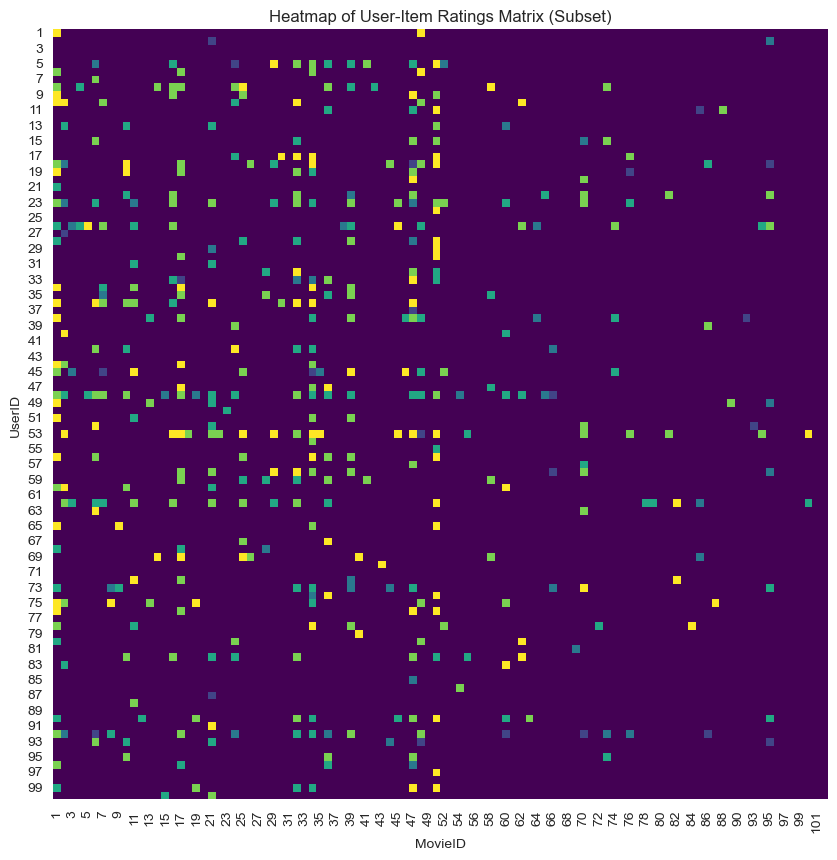

In [9]:
import seaborn as sns

# Take a subset of the user-item matrix for visualization
subset_matrix = user_item_matrix.iloc[:100, :100]

plt.figure(figsize=(10, 10))
sns.heatmap(subset_matrix, cmap='viridis', cbar=False)
plt.title('Heatmap of User-Item Ratings Matrix (Subset)')
plt.xlabel('MovieID')
plt.ylabel('UserID')
plt.show()

We now move on to the task of predicting the rate that a users may assign to a movie using a machine learning regression method (called random forest) using with hand-picked features. As features, we use the movie's genre (in a one-shot encoder) and user's age, gender, and occupation. We also use a graph-based feature typically used in recommendation systems. This feature is computed following two steps: (Step 1) compute the cosine similarity between users based on their rating patterns and (Step 2) include the average rating from the top-N similar users for a movie as an additional feature.

Let's us start by encoding the vector of features based on given attributes...

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# One-hot encode movie genres
movies_genres = movies['Genres'].str.get_dummies(sep='|')

# One-hot encode user's occupation
users_occupation = pd.get_dummies(users['Occupation'], prefix='Occupation')

# Encode gender as binary
users['Gender'] = users['Gender'].map({'F': 0, 'M': 1})

# Combine user features
users_features = pd.concat([users[['UserID', 'Age', 'Gender']], users_occupation], axis=1)

# Merge ratings with user features and movie genres
ratings = ratings.merge(users_features, on='UserID')
ratings = ratings.merge(movies_genres, left_on='MovieID', right_index=True)

Let's continue with the computation of the graph-based collaborative feature based on cosine similarities... (be patient, this takes a while! Make sure you run this in your own computer, not on the cloud, e.g. Colab)

In [11]:
# Create a user-item matrix for cosine similarity calculation
user_item_matrix = ratings.pivot_table(index='UserID', columns='MovieID', values='Rating').fillna(0)

# Compute user-user cosine similarity
user_similarity = cosine_similarity(user_item_matrix)

# For each user-movie pair, calculate the average rating from top-N similar users
def get_similar_users_rating(row, top_n=10):
    similar_users = np.argsort(-user_similarity[row['UserID'] - 1])[:top_n]
    similar_users_ratings = user_item_matrix.iloc[similar_users, user_item_matrix.columns.get_loc(row['MovieID'])]
    return np.nanmean(similar_users_ratings)

ratings['SimilarUsersRating'] = ratings.apply(get_similar_users_rating, axis=1)

We now use the Random Forest Regressor to train a movie rating predictor based on the features engineered above. We use the Random Forest Regressor as our machine learning model due to its versatility, ease of use, and ability to handle both numerical and categorical data effectively.

In [12]:
# Prepare the dataset for training
X = ratings.drop(['UserID', 'MovieID', 'Rating', 'Timestamp'], axis=1)
y = ratings['Rating']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.086903939269786


Apart from predicting the rate a user assigns to a movie, we can use the user-user similarity matrix (built using cosine similarity) to find clusters of users with similar movie taste.
Spectral clustering uses the eigenvalues of the similarity matrix to perform dimensionality reduction before clustering in fewer dimensions.

In [13]:
from sklearn.cluster import SpectralClustering

# Define the number of clusters
n_clusters = 5  # For example, let's cluster users into 5 groups

# Perform spectral clustering
clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_init=100, assign_labels='discretize')
user_labels = clustering.fit_predict(user_similarity)

# user_labels now contains the cluster label for each user

Let's visualize the clusters of users with similar movie taste using a 2D spectral embedding...

In [14]:
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt
import numpy as np

# Compute the spectral embedding
embedding = SpectralEmbedding(n_components=2, affinity='precomputed', random_state=42)
user_embedding_2d = embedding.fit_transform(user_similarity)

Now, plot the users in the two-dimensional space defined by the spectral embedding, coloring each user by their cluster label:

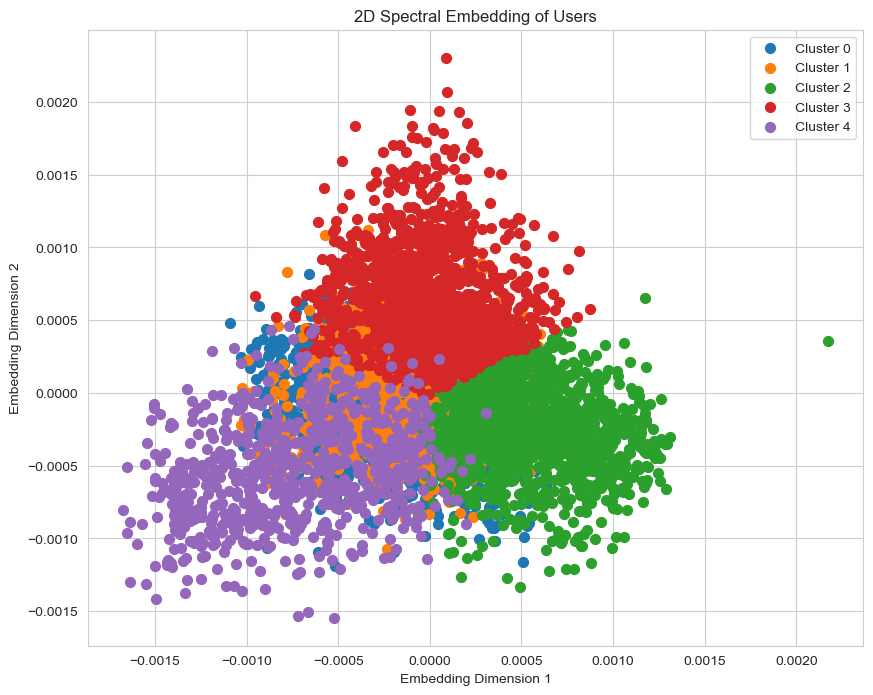

In [15]:
# Plot
plt.figure(figsize=(10, 8))

# Scatter plot for each cluster
for i in range(n_clusters):
    # Select the indices for data points in cluster i
    indices = np.where(user_labels == i)
    plt.scatter(user_embedding_2d[indices, 0], user_embedding_2d[indices, 1], label=f'Cluster {i}', s=50)

plt.title('2D Spectral Embedding of Users')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.legend()
plt.show()

Notice that this is a 2D projection of a spectral clustering that took place in a 4D embedding (since K=5, d=4).